# Import

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms, datasets
from matplotlib import pyplot as plt
import copy
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

# Import data directly from Kaggle and caches the dataset for further use

In [3]:
dataset_path = '../dataset'

if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
    print("Dataset not found. Downloading now...")
    
    %pip install --quiet kaggle
    
    os.makedirs(dataset_path, exist_ok=True)
    
    !kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification -p {dataset_path}
    
    import zipfile
    with zipfile.ZipFile(os.path.join(dataset_path, 'muffin-vs-chihuahua-image-classification.zip'), 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(os.path.join(dataset_path, 'muffin-vs-chihuahua-image-classification.zip'))
    
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists. Using cached version.")


Dataset already exists. Using cached version.


## Load and split data

In [4]:
# Chemins des répertoires train et test
train_dir = '../dataset/train'
test_dir = '../dataset/test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),                          # Resize les images à 224x224 pixels
    transforms.ToTensor(),                                  # Convertir l'image en tenseur
])

# Charger le dataset d'entraînement complet
train_data = datasets.ImageFolder(root=train_dir, transform=transform)

# Définir les proportions pour l'entraînement et la validation
train_size = int(0.8 * len(train_data))  # 80% pour l'entraînement
valid_size = len(train_data) - train_size  # 20% pour la validation

# Diviser le dataset d'entraînement en entraînement et validation
train_data, valid_data = random_split(train_data, [train_size, valid_size])

# Charger le dataset de test
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Définir la taille des batches
batch_size = 32

# Créer les DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Vérification des tailles
print(f"Taille du train_loader: {len(train_loader.dataset)} images")
print(f"Taille du valid_loader: {len(valid_loader.dataset)} images")
print(f"Taille du test_loader: {len(test_loader.dataset)} images")


Taille du train_loader: 3786 images
Taille du valid_loader: 947 images
Taille du test_loader: 1184 images


## Visualization of the training images

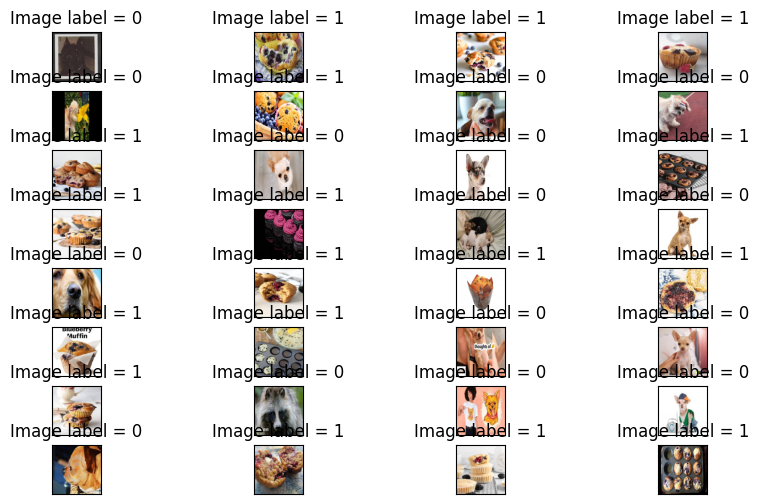

In [5]:
image_batch_example, labels_batch_example = next(iter(train_loader))

plt.figure(figsize=(10, 6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib + 1)
    
    image = image_batch_example[ib].permute(1, 2, 0).detach().numpy()

    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
    
plt.show()

# Model

## Init model parameters

In [6]:
def init_params(m, seed=0):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, generator=torch.manual_seed(seed))
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, mean=1, std=0.02, generator=torch.manual_seed(seed))
        m.bias.data.fill_(0.01)
    return

# Premier modèle CNN non concluant

Nous avons tester plusieurs modèles. Dans un premier temps nous avons testé un modèle avec 3 couches de convolution et deux couches full connecté (modèle juste en dessous). 

## Définition du modèle

In [32]:
class CNNClassif_2(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_channels3=64, num_classes=2):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, num_channels1, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(num_channels2, num_channels3, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        
        self.flatten = nn.Flatten()

        self._initialize_input_size()
        
        self.fc1 = nn.Linear(self.input_size_linear, 128)  
        self.fc2 = nn.Linear(128, num_classes)  

    def _initialize_input_size(self):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)  
            out = self.conv_block1(dummy_input)
            out = self.conv_block2(out)
            out = self.conv_block3(out)
            self.input_size_linear = out.view(-1).size(0)

    def forward(self, x):
        out1 = self.conv_block1(x)
        out2 = self.conv_block2(out1)
        out3 = self.conv_block3(out2)
        
        out_flat = self.flatten(out3)
        
        out_fc1 = F.relu(self.fc1(out_flat))
        out_fc2 = self.fc2(out_fc1)
        
        output = F.sigmoid(out_fc2)
        
        return output

## Création du modèle

In [33]:
model2 = CNNClassif_2()

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model2.parameters()))

# initialization of the network's parameters
model2.apply(init_params)

Total number of parameters:  6446498


CNNClassif_2(
  (conv_block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

On remarque que le modèle est assez complexe et possède un grand nombre de paramètres.

## Évaluation du modèle

In [15]:
def eval_cnn_classifier(model, eval_dataloader):
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            #images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

def train_val_cnn_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, verbose=True, seed=0):
    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []

    best_model = (copy.deepcopy(model_tr), 0)
    val_accuracy = []
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialize the training loss for the current epoch
        tr_loss = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            #img_vectorize = images.view(images.shape[0], 1*28*28)
            y_pred = model_tr.forward(images)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
           
            # For each batch, we update the current epoch loss
            tr_loss += loss.item()  

        # At the end of each epoch, get the average training loss over all batches
        tr_loss = tr_loss / len(train_dataloader)
        train_losses.append(tr_loss)

        accuracy = eval_cnn_classifier(model_tr,valid_dataloader)
        if accuracy > best_model[1]:
            best_model = (copy.deepcopy(model_tr), accuracy)
            
        val_accuracy.append(accuracy)
        
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}, Accuracy : {:.4f}'.format(epoch+1, num_epochs, tr_loss, accuracy))

    
    return best_model, train_losses, val_accuracy

## Visualisation des performances

Epoch [1/10], Training loss: 0.6947, Accuracy : 46.4625
Epoch [2/10], Training loss: 0.6931, Accuracy : 46.4625
Epoch [3/10], Training loss: 0.6931, Accuracy : 46.4625
Epoch [4/10], Training loss: 0.6931, Accuracy : 46.4625
Epoch [5/10], Training loss: 0.6931, Accuracy : 46.4625
Epoch [6/10], Training loss: 0.6931, Accuracy : 46.4625
Epoch [7/10], Training loss: 0.6931, Accuracy : 46.4625
Epoch [8/10], Training loss: 0.6931, Accuracy : 46.4625
Epoch [9/10], Training loss: 0.6931, Accuracy : 46.4625
Epoch [10/10], Training loss: 0.6931, Accuracy : 46.4625


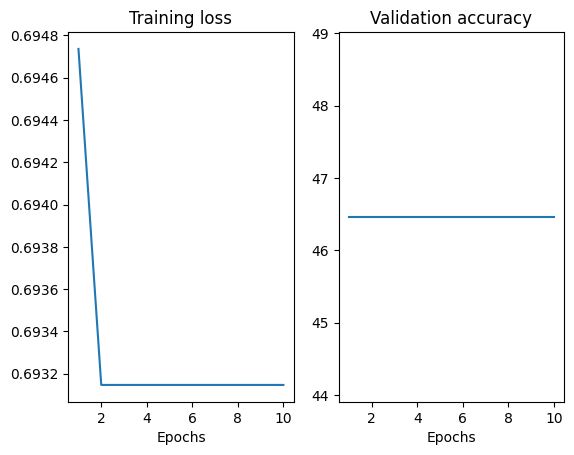

In [30]:
# Optimizer
num_epochs = 10
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model_tr2, train_losses2, val_accuracies2 = train_val_cnn_classifier(model2, train_loader, valid_loader, num_epochs, loss_fn, learning_rate, verbose=True)

# Display the training loss and validation accuracy over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, train_losses2)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, val_accuracies2)
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.show()

Cependant, nous avons eu un problème d'accuracy. En effet, comme on peut le voir sur les graphique, l'accuracy est constante à travers les epochs. Nous avons donc essayer de changer plusieurs paramètres pour voir d'où venait le problème. 
Nous pensions au début, que le problème venait des données. On croyait qu'elles étaient mal réaprtis. Nous aovns donc changé le code pour tester de répartir les données de manière différente mais cela n'avait aucune répercution.
Nous avons également essayé de changer le taux d'apprentissage, puis les fonctions d'activations sur la dernière couche ou encore normaliser nos données. 
Finalement, aucun de ces changements n'a affecté le comportement de l'accuracy. 
Nous avons conclus que le problème venait de notre modèle. L'hypothèse étant qu'il était trop complexe pour nos problème de classification. 

Pour tester cette hypothèse, nous avons récupérer le modèle vu en cours lors du TD n°5. Nous l'avons utiliser comme modèle de référence afin de comparer les résultats. 

# Modèle de référence

## Création du modèle

In [12]:
class CNNClassif(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_classes=2):
        super().__init__()
        self.input = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.hidden = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.output = nn.Sequential(nn.Linear(input_size_linear, num_classes), nn.Sigmoid())
        pass 
       
    def forward(self, x):
        out1 = self.input(x)
        out2 = self.hidden(out1)
        out3 = self.output(out2.reshape(out2.shape[0], -1))
        return out3

## Instanciation du modèle

In [36]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 2
input_size_linear = num_channels2 * 56 * 56
model = CNNClassif(input_size_linear, num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

# initialization of the network's parameters
model.apply(init_params)

Total number of parameters:  214754


CNNClassif(
  (input): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output): Sequential(
    (0): Linear(in_features=100352, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

On remarque que le modèle est bien plus simple car il est composé de deux couches de convolutions et une couche d'output linéair. Le nombre de paramètre est donc bien plus faible que le premier modèle que nous avons fait.

## Évaluation du modèle

Pour évaluation ce modèle nous avons utiliser la même fonction utilisre précédemment. 

## Visualisation des performances du modèle

Epoch [1/10], Training loss: 0.5398, Accuracy : 75.7128
Epoch [2/10], Training loss: 0.4932, Accuracy : 79.8310
Epoch [3/10], Training loss: 0.4574, Accuracy : 82.2598
Epoch [4/10], Training loss: 0.4367, Accuracy : 81.2038
Epoch [5/10], Training loss: 0.4162, Accuracy : 84.3717
Epoch [6/10], Training loss: 0.3945, Accuracy : 83.5269
Epoch [7/10], Training loss: 0.3806, Accuracy : 84.2661
Epoch [8/10], Training loss: 0.3712, Accuracy : 84.1605
Epoch [9/10], Training loss: 0.3608, Accuracy : 84.0549
Epoch [10/10], Training loss: 0.3600, Accuracy : 85.3221


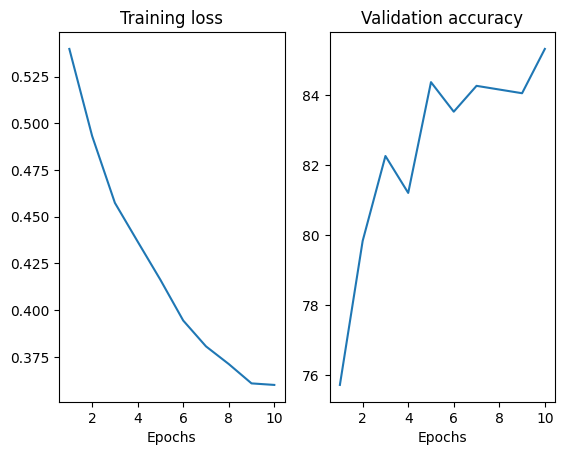

In [37]:
# Optimizer
num_epochs = 10
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model_tr, train_losses, val_accuracies = train_val_cnn_classifier(model, train_loader, valid_loader, num_epochs, loss_fn, learning_rate, verbose=True)

# Display the training loss and validation accuracy over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, train_losses)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, val_accuracies)
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.show()

En utilisant ce modèle, nous avons pu confirmer notre hypothèse. Notre modèle d'origine est bien trop complexe pour cette tâche de classification. 


## Test du modèle

In [39]:
def test_model(model, test_dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    failed_examples = []
    correct_labels = 0
    total_labels = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(label_predicted.numpy())
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
            # Store failed examples
            for i in range(len(labels)):
                if labels[i] != label_predicted[i]:
                    failed_examples.append((images[i], labels[i].item(), label_predicted[i].item()))
    # Calculate accuracy
    accuracy = 100 * correct_labels / total_labels
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    # Calculate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plotting a few failed examples
    num_failed_examples = min(8, len(failed_examples))
    if num_failed_examples > 0:
        plt.figure(figsize=(12, 6))
        for i in range(num_failed_examples):
            image, true_label, predicted_label = failed_examples[i]
            plt.subplot(2, 4, i + 1)
            plt.imshow(image.permute(1, 2, 0).numpy())
            plt.title(f'True: {true_label}, Pred: {predicted_label}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

## Visualization

Test Accuracy: 85.56%


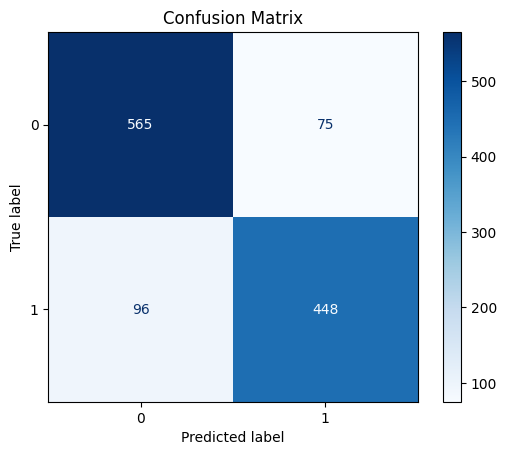

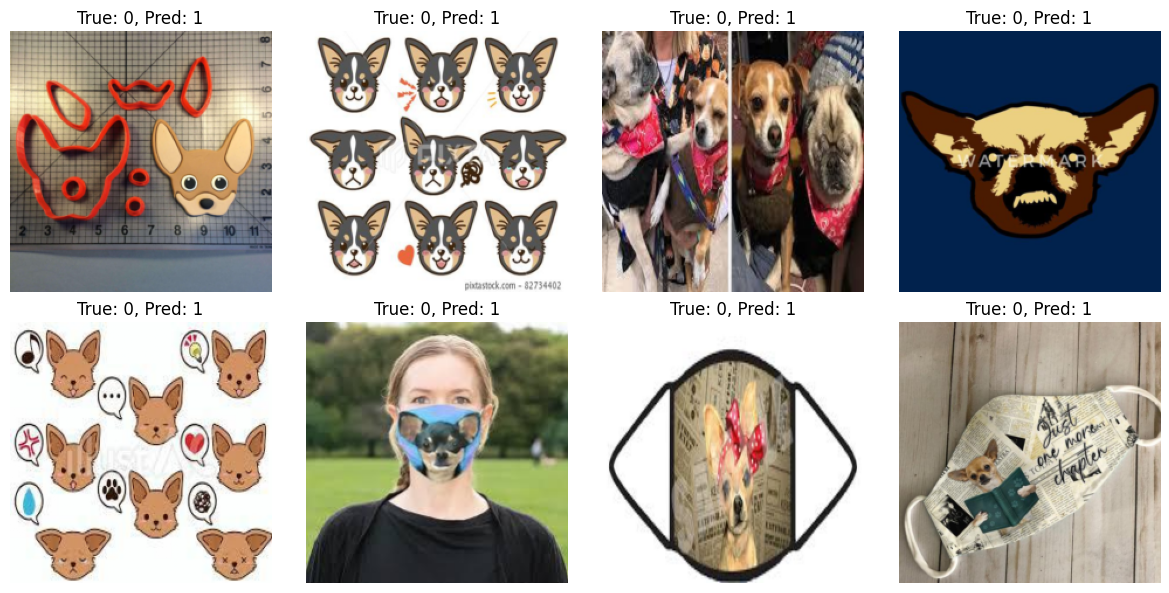

In [38]:
# Testing the model
test_model(model_tr[0], test_loader)

Nous avons voulu testé notre modèle avec les données de test afin de voir si le modèle n'a pas de problème overfitting par exemple. Finalement, nous avons obtenue une accuracy de 85.56% ce qui est cohérent avec les résultats d'entraînement.

# 3ème modèle

## Création du modèle

In [35]:
class CNNClassif3(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_channels3=64, num_classes=2):
        super().__init__()
        
        self.input = nn.Sequential(
            nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) 
        )
        
        self.hidden = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  
        )
        
        self.hidden2 = nn.Sequential(
            nn.Conv2d(num_channels2, num_channels3, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  
        )
        
        self.output = nn.Sequential(
            nn.Linear(input_size_linear, num_classes),  
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        out1 = self.input(x)
        out2 = self.hidden(out1)
        out3 = self.hidden2(out2)
        
        out4 = out3.reshape(out3.shape[0], -1)
        
        out5 = self.output(out4)
        return out5


## Instanciation du modèle

In [36]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_channels3 = 64
num_classes = 2
input_size_linear = num_channels3 * 28 * 28
model3 = CNNClassif3(input_size_linear, num_channels1, num_channels2, num_channels3, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model3.parameters()))

# initialization of the network's parameters
model3.apply(init_params)

Total number of parameters:  132898


CNNClassif3(
  (input): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (output): Sequential(
    (0): Linear(in_features=50176, out_features=2, bias=True)
    (1): Sigmoid()
  )
)

Nous avons ajouter une couche de convolution par rapport au modèle de référence.

## Évaluation du modèle

Epoch [1/20], Training loss: 0.5737, Accuracy : 80.8870
Epoch [2/20], Training loss: 0.4962, Accuracy : 81.8374
Epoch [3/20], Training loss: 0.4780, Accuracy : 80.8870
Epoch [4/20], Training loss: 0.4635, Accuracy : 83.2101
Epoch [5/20], Training loss: 0.4522, Accuracy : 84.6885
Epoch [6/20], Training loss: 0.4433, Accuracy : 84.2661
Epoch [7/20], Training loss: 0.4332, Accuracy : 85.5333
Epoch [8/20], Training loss: 0.4228, Accuracy : 86.2724
Epoch [9/20], Training loss: 0.4123, Accuracy : 86.5892
Epoch [10/20], Training loss: 0.4072, Accuracy : 86.3780
Epoch [11/20], Training loss: 0.3973, Accuracy : 86.8004
Epoch [12/20], Training loss: 0.3891, Accuracy : 87.5396
Epoch [13/20], Training loss: 0.3827, Accuracy : 86.5892
Epoch [14/20], Training loss: 0.3774, Accuracy : 88.1732
Epoch [15/20], Training loss: 0.3685, Accuracy : 85.3221
Epoch [16/20], Training loss: 0.3692, Accuracy : 83.2101
Epoch [17/20], Training loss: 0.3686, Accuracy : 86.2724
Epoch [18/20], Training loss: 0.3686, Ac

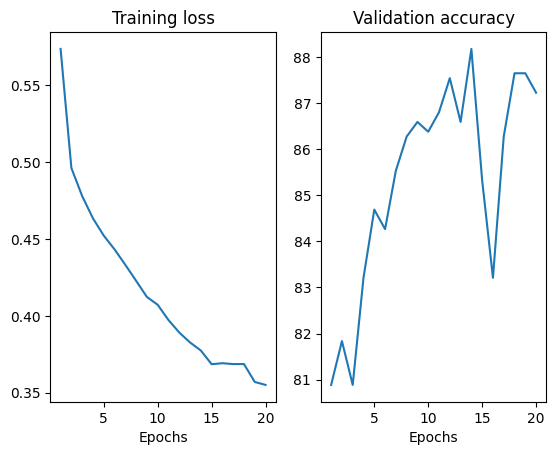

In [37]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model_tr3, train_losses3, val_accuracies3 = train_val_cnn_classifier(model3, train_loader, valid_loader, num_epochs, loss_fn, learning_rate, verbose=True)

# Display the training loss and validation accuracy over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, train_losses3)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, val_accuracies3)
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.show()

## test du modèle

Test Accuracy: 87.25%


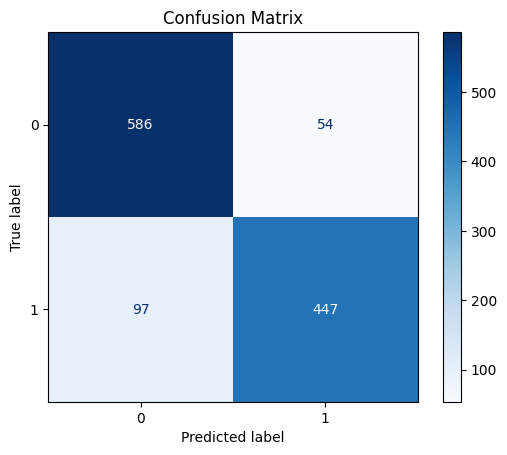

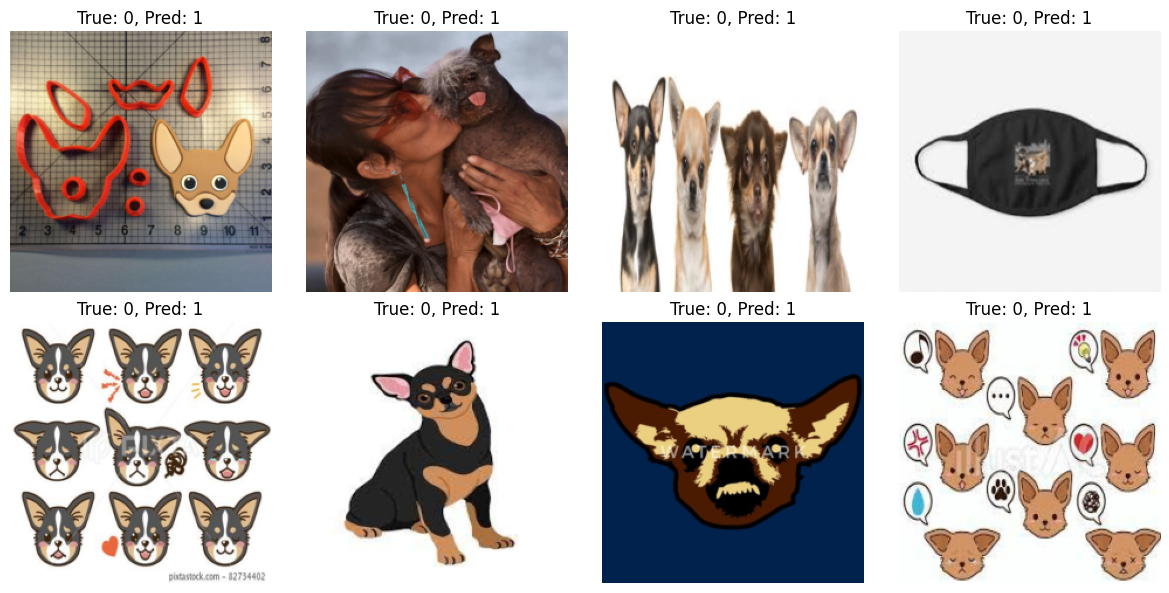

In [40]:
test_model(model_tr3[0], test_loader)

# 4eme modèle

On a essayé 4 couches de convolutions, mais ça n'a pas été concluant car notre loss et accuracy stagnent de nouveau. Nous avons donc choisi d'essayer d'améliorer le modèle numéro 3 en ajoutant de la normalisation de batch et des dropout. De plus nous souhaitons augmenter le nombre de epochs, car comme on peut le voir sur le graphique de la loss par epochs la loss semble pouvoir encore diminuer.

In [26]:
class CNNClassif4(nn.Module):
    def __init__(self, input_size_linear, num_channels1=16, num_channels2=32, num_channels3=64, num_classes=2):
        super().__init__()
        
        self.input = nn.Sequential(
            nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_channels1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)  
        )
        
        self.hidden = nn.Sequential(
            nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_channels2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Conv2d(num_channels2, num_channels3, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_channels3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3)
        )
        
        self.output = nn.Sequential(
            nn.Linear(input_size_linear, num_classes),  
            nn.Sigmoid()  
        )
    
    def forward(self, x):
        out1 = self.input(x)
        out2 = self.hidden(out1)
        out3 = self.hidden2(out2)
        
        out4 = out3.reshape(out3.shape[0], -1)
        
        out5 = self.output(out4)
        return out5


## Instanciation du modèle

In [29]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_channels3 = 64
num_classes = 2
input_size_linear = num_channels3 * 28 * 28
model4 = CNNClassif4(input_size_linear, num_channels1, num_channels2, num_channels3, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model4.parameters()))

# initialization of the network's parameters
model4.apply(init_params)

Total number of parameters:  133122


CNNClassif4(
  (input): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (hidden): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (hidden2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)

## Évaluation du modèle

In [32]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model_tr4, train_losses4, val_accuracies4= train_val_cnn_classifier(model4, train_loader, valid_loader, num_epochs, loss_fn, learning_rate, verbose=True)

# Display the training loss and validation accuracy over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(torch.arange(num_epochs)+1, train_losses4)
plt.title('Training loss')
plt.xlabel('Epochs')
plt.subplot(1, 2, 2)
plt.plot(torch.arange(num_epochs)+1, val_accuracies4)
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.show()

Epoch [1/20], Training loss: 0.8499, Accuracy : 44.3506
Epoch [2/20], Training loss: 0.8498, Accuracy : 44.3506
Epoch [3/20], Training loss: 0.7083, Accuracy : 55.6494
Epoch [4/20], Training loss: 0.6931, Accuracy : 55.6494
Epoch [5/20], Training loss: 0.6931, Accuracy : 55.6494
Epoch [6/20], Training loss: 0.6931, Accuracy : 55.6494
Epoch [7/20], Training loss: 0.6931, Accuracy : 55.6494
Epoch [8/20], Training loss: 0.6931, Accuracy : 55.6494


KeyboardInterrupt: 

Nous avons voulu changer la fonction d'activation pour utiliser BCE With Logits Loss, cepandant nous avons eu un problème avec la shape de ypred dans la fonction d'évaluation donc nous avons laisser Cross Entropy Loss

# Sauvegarde du modèle

In [26]:
with open('cnn_classifier_model.pkl', 'wb') as f:
    pickle.dump(model_tr, f)

Nous souhaitons utiliser ce modèle comme référence en augmentant légèrement ça complexité afin de voir si cela permettrait d'avoir une meilleure accuracy.